# Big American Pharma acquisition of SFB

The BAP acquisition of SFB has arisen the need to plan the workforce in the new merged entity. Hence, John and Kusha have taken the steps given below to come up with a predictive model determining probability of employees leaving the organisation and thereafter be offering RCC to such employees by categorising them into groups.

### 1. Pre-processing of employee attrition data from previous closure

In [1]:
#Load Modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn import decomposition as dcp
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

Next, We will import the dataset and further sub-divide it into training, validation and testing datasets for independent pre-processing in order to avoid training testing contamination. 

In [2]:
#Import Dataset - Previous closure conducted by Nikitha
prev_cl = pd.read_csv("employee_attrition_previous_closure.csv")

#Dividing the dataset into train (50%), validation (25%) and testing (25%) sets to avoid training testing contamination
prev_cl_train = prev_cl.sample(frac = 0.5, random_state = 1) #Train set

#Removing training set for selection of validation set
df_val = prev_cl.drop(prev_cl_train.index)
prev_cl_val = df_val.sample(frac = 0.5, random_state = 1) #Validation Set

#Removing training set for selection of testing set
df_test = df_val.drop(prev_cl_val.index)
prev_cl_test = df_test.sample(frac = 1, random_state = 1) #Testing Set

In [3]:
#Checking for any duplicate values
prev_cl_train_dups = prev_cl_train.duplicated()
print(prev_cl_train_dups.any())

False


In [4]:
prev_cl_val_dups = prev_cl_val.duplicated()
print(prev_cl_val_dups.any())

False


In [5]:
prev_cl_test_dups = prev_cl_test.duplicated()
print(prev_cl_test_dups.any())

False


We will further check whether any of the columns have the same value across all the employees and watch out for any columns with redundant information and thereafter remove these from the dataset since they do not have any informative value.

In [6]:
#Drop columns with a single value for all rows due to no informative value
#Removing employee number as well due to no informative value
prev_cl_train.nunique()
prev_cl_train2 = prev_cl_train.drop(["EmployeeCount","Over18","StandardHours","EmployeeNumber"], axis = 1)
prev_cl_train2

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
339,40.0,No,NaN,616.0,Research & Development,2.0,2,Life Sciences,3,Female,...,3,4,1,7,5,2,4,3,0,2
244,52.0,No,Travel_Frequently,322.0,Research & Development,28.0,2,Medical,4,Female,...,3,2,1,24,3,2,5,3,0,2
848,32.0,Yes,Travel_Rarely,414.0,Sales,2.0,4,Marketing,3,Male,...,3,3,0,7,3,2,2,2,2,2
567,53.0,No,Travel_Frequently,124.0,Sales,2.0,3,Marketing,3,Female,...,3,1,1,30,2,3,15,7,6,12
922,40.0,No,Travel_Rarely,555.0,Research & Development,2.0,3,Medical,2,Female,...,4,2,1,20,3,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,36.0,No,Travel_Rarely,1278.0,Human Resources,8.0,3,Life Sciences,1,Male,...,4,3,0,6,3,3,5,4,0,3
584,48.0,No,Travel_Rarely,855.0,Research & Development,4.0,3,Life Sciences,4,Male,...,3,3,0,11,2,3,10,9,0,8
359,27.0,No,Travel_Rarely,1055.0,Research & Development,2.0,4,Life Sciences,1,Female,...,3,2,1,4,2,3,3,2,2,2
523,NaN,Yes,Travel_Rarely,529.0,Research & Development,2.0,4,Life Sciences,1,Male,...,3,3,0,5,5,1,0,0,0,0


In [7]:
prev_cl_val.nunique()
prev_cl_val2 = prev_cl_val.drop(["EmployeeCount","Over18","StandardHours", "EmployeeNumber"], axis = 1) #Removing employee number as well due to no informative value
prev_cl_val2

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
122,34.0,No,Travel_Rarely,1397.0,Research & Development,1.0,5,Life Sciences,2,Male,...,3,4,1,10,4,2,10,9,8,8
677,19.0,No,Travel_Rarely,1181.0,Research & Development,NaN,1,Medical,2,Female,...,3,4,0,1,3,3,1,0,0,0
564,NaN,No,Travel_Rarely,1179.0,Research & Development,19.0,4,Medical,4,Male,...,3,3,3,6,2,3,6,5,3,3
448,36.0,Yes,Travel_Rarely,318.0,Research & Development,9.0,3,Medical,4,Male,...,3,1,1,2,0,2,1,0,0,0
1012,29.0,Yes,Travel_Frequently,459.0,Research & Development,24.0,2,Life Sciences,4,Male,...,4,2,0,1,3,2,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,34.0,Yes,Non-Travel,967.0,Research & Development,16.0,4,Technical Degree,4,Male,...,4,2,1,5,2,3,5,2,3,0
876,34.0,No,Travel_Rarely,1442.0,Research & Development,9.0,3,Medical,4,Female,...,3,2,0,9,3,4,8,7,7,7
811,30.0,No,Travel_Rarely,1082.0,Sales,12.0,3,Technical Degree,2,Female,...,3,2,0,6,6,3,5,4,4,4
695,27.0,No,Travel_Frequently,1297.0,Research & Development,NaN,2,Life Sciences,4,Female,...,3,3,0,6,3,2,5,4,0,2


In [8]:
prev_cl_test.nunique()
prev_cl_test2 = prev_cl_test.drop(["EmployeeCount","Over18","StandardHours","EmployeeNumber"], axis = 1) #Removing employee number as well due to no informative value
prev_cl_test2

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
707,19.0,No,Travel_Rarely,645.0,Research & Development,9.0,2,Life Sciences,3,Male,...,4,3,0,1,4,3,1,1,0,0
149,56.0,No,Travel_Frequently,1240.0,Research & Development,9.0,3,Medical,1,Female,...,3,2,1,18,4,3,5,4,0,3
716,36.0,No,Travel_Frequently,688.0,Research & Development,4.0,2,Life Sciences,4,Female,...,3,2,3,18,3,3,4,2,0,2
932,36.0,No,Travel_Rarely,311.0,Research & Development,7.0,3,Life Sciences,1,Male,...,3,3,0,15,4,3,4,3,1,3
855,40.0,No,Travel_Rarely,750.0,Research & Development,12.0,3,Life Sciences,2,Female,...,3,2,1,15,3,3,7,4,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,46.0,No,Non-Travel,849.0,Sales,26.0,2,Life Sciences,2,Male,...,3,3,0,6,3,3,2,2,2,2
302,41.0,No,Travel_Frequently,840.0,Research & Development,9.0,3,Medical,1,Male,...,3,2,1,21,2,4,18,16,0,11
547,33.0,No,Travel_Rarely,1069.0,Research & Development,1.0,3,Life Sciences,2,Female,...,3,1,0,6,3,3,5,0,1,4
935,55.0,No,Travel_Rarely,1311.0,Research & Development,2.0,3,Life Sciences,3,Female,...,3,3,0,30,2,3,5,4,1,2


We will further check for any missing values and fill them with appropriate methods. The method of filling up each of the missing value columns is given below: 

AGE - Nearest row value

BUSINESS TRAVEL, MARITAL STATUS - Most frequent values in their respective columns

DAILY RATE, DISTANCE FROM HOME - Average of other rows in their respective columns

In [9]:
#Checking for missing values

prev_cl_train2.isna().sum()

Age                         60
Attrition                    0
BusinessTravel               2
DailyRate                   12
Department                   0
DistanceFromHome            46
Education                    0
EducationField               0
EnvironmentSatisfaction      0
Gender                       0
HourlyRate                   0
JobInvolvement               0
JobLevel                     0
JobRole                      0
JobSatisfaction              0
MaritalStatus                2
MonthlyIncome                0
MonthlyRate                  0
NumCompaniesWorked           0
OverTime                     0
PercentSalaryHike            0
PerformanceRating            0
RelationshipSatisfaction     0
StockOptionLevel             0
TotalWorkingYears            0
TrainingTimesLastYear        0
WorkLifeBalance              0
YearsAtCompany               0
YearsInCurrentRole           0
YearsSinceLastPromotion      0
YearsWithCurrManager         0
dtype: int64

In [10]:
prev_cl_val2.isna().sum()

Age                         45
Attrition                    0
BusinessTravel               1
DailyRate                    8
Department                   0
DistanceFromHome            24
Education                    0
EducationField               0
EnvironmentSatisfaction      0
Gender                       0
HourlyRate                   0
JobInvolvement               0
JobLevel                     0
JobRole                      0
JobSatisfaction              0
MaritalStatus                3
MonthlyIncome                0
MonthlyRate                  0
NumCompaniesWorked           0
OverTime                     0
PercentSalaryHike            0
PerformanceRating            0
RelationshipSatisfaction     0
StockOptionLevel             0
TotalWorkingYears            0
TrainingTimesLastYear        0
WorkLifeBalance              0
YearsAtCompany               0
YearsInCurrentRole           0
YearsSinceLastPromotion      0
YearsWithCurrManager         0
dtype: int64

In [11]:
prev_cl_test2.isna().sum()

Age                         31
Attrition                    0
BusinessTravel               2
DailyRate                    7
Department                   0
DistanceFromHome            25
Education                    0
EducationField               0
EnvironmentSatisfaction      0
Gender                       0
HourlyRate                   0
JobInvolvement               0
JobLevel                     0
JobRole                      0
JobSatisfaction              0
MaritalStatus                0
MonthlyIncome                0
MonthlyRate                  0
NumCompaniesWorked           0
OverTime                     0
PercentSalaryHike            0
PerformanceRating            0
RelationshipSatisfaction     0
StockOptionLevel             0
TotalWorkingYears            0
TrainingTimesLastYear        0
WorkLifeBalance              0
YearsAtCompany               0
YearsInCurrentRole           0
YearsSinceLastPromotion      0
YearsWithCurrManager         0
dtype: int64

In [12]:
#Imputation of missing values for all the three datasets using relevant methods, as given below:

#For 'Age' we use a NEAREST ROW VALUE approach
imputer = KNNImputer(n_neighbors=1)
prev_cl_train2[["Age"]] = imputer.fit_transform(prev_cl_train2[["Age"]])
prev_cl_val2[["Age"]] = imputer.fit_transform(prev_cl_val2[["Age"]])
prev_cl_test2[["Age"]] = imputer.fit_transform(prev_cl_test2[["Age"]])

#For 'Business Travel' and 'Marital Status'(Only Train set), we use the MOST FREQUENT VALUES to impute the missing ones
imp=SimpleImputer(missing_values=np.nan, strategy="most_frequent")
prev_cl_train2[["BusinessTravel","MaritalStatus"]]=imp.fit_transform(prev_cl_train2[["BusinessTravel","MaritalStatus"]])
prev_cl_val2[["BusinessTravel"]]=imp.fit_transform(prev_cl_val2[["BusinessTravel"]])
prev_cl_test2[["BusinessTravel"]]=imp.fit_transform(prev_cl_test2[["BusinessTravel"]])

#For 'Daily Rate' and 'Distance from Home' filling missing values using the AVERAGE of other rows in the same column
imp=SimpleImputer(missing_values=np.nan, strategy="mean")
prev_cl_train2[["DailyRate","DistanceFromHome"]]=imp.fit_transform(prev_cl_train2[["DailyRate","DistanceFromHome"]])
prev_cl_val2[["DailyRate","DistanceFromHome"]]=imp.fit_transform(prev_cl_val2[["DailyRate","DistanceFromHome"]])
prev_cl_test2[["DailyRate","DistanceFromHome"]]=imp.fit_transform(prev_cl_test2[["DailyRate","DistanceFromHome"]])

Next in line, we convert the categorical variables into numerical/dummy variables (one hot encoding) for convenience in scaling (normalising) the data.

In [13]:
#Converting categorical variables into Numerical Variables (one hot encoding) for the purpose of normalising the data
prev_cl_train3 = pd.get_dummies(prev_cl_train2, drop_first = True)
prev_cl_val3 = pd.get_dummies(prev_cl_val2, drop_first = True)
prev_cl_test3 = pd.get_dummies(prev_cl_test2, drop_first = True)

We further check whether any of the columns could be merged to convey information which might be helpful in lending an objective view to the analysis confucted. Hence, we have been able to generate three new features, as given below:

CURRENT_ROLE_TENURE PERCENTAGE - Proportion of tenure at the current company spent on the current role

COMPANY_TENURE_PERCENTAGE - Proportion of total working years spent in the current company

MANAGER_TENURE_PERCENTAGE - Proportion of years at the company spent with the current manager

In [14]:
#Adding and removing features for all the three datasets (features added from a more informative variable point of view)

##Adding a new feature combining years in current role and years in the company to get proportion of time spent on the current role, and drop years in current role
prev_cl_train3["currentrole_tenure_percentage"]=prev_cl_train3["YearsInCurrentRole"]/prev_cl_train3["YearsAtCompany"]
prev_cl_val3["currentrole_tenure_percentage"]=prev_cl_val3["YearsInCurrentRole"]/prev_cl_val3["YearsAtCompany"]
prev_cl_test3["currentrole_tenure_percentage"]=prev_cl_test3["YearsInCurrentRole"]/prev_cl_test3["YearsAtCompany"]

##Adding a feature to check proportion of time spent at current company in comparison with total working years
prev_cl_train3["company_tenure_percentage"]=prev_cl_train3["YearsAtCompany"]/prev_cl_train3["TotalWorkingYears"]
prev_cl_val3["company_tenure_percentage"]=prev_cl_val3["YearsAtCompany"]/prev_cl_val3["TotalWorkingYears"]
prev_cl_test3["company_tenure_percentage"]=prev_cl_test3["YearsAtCompany"]/prev_cl_test3["TotalWorkingYears"]

##Adding a feature to check to proportion of total time in the company spent with the current manager
prev_cl_train3["manager_tenure_percentage"]=prev_cl_train3["YearsWithCurrManager"]/prev_cl_train3["YearsAtCompany"]
prev_cl_val3["manager_tenure_percentage"]=prev_cl_val3["YearsWithCurrManager"]/prev_cl_val3["YearsAtCompany"]
prev_cl_test3["manager_tenure_percentage"]=prev_cl_test3["YearsWithCurrManager"]/prev_cl_test3["YearsAtCompany"]

##Drop total working years, years in current role and years with current manager from the dataset (keeping years in company since that might be a effective determinant of RCC acceptance due to it being used as a base to decide severance packages)
prev_cl_train4 = prev_cl_train3.drop(["TotalWorkingYears", "YearsInCurrentRole", "YearsWithCurrManager"], axis = 1)
prev_cl_val4 = prev_cl_val3.drop(["TotalWorkingYears", "YearsInCurrentRole", "YearsWithCurrManager"], axis = 1)
prev_cl_test4 = prev_cl_test3.drop(["TotalWorkingYears", "YearsInCurrentRole", "YearsWithCurrManager"], axis = 1)

In [15]:
#Check for any missing values post addition and removal of features
prev_cl_train4.isna().sum()

Age                                   0
DailyRate                             0
DistanceFromHome                      0
Education                             0
EnvironmentSatisfaction               0
HourlyRate                            0
JobInvolvement                        0
JobLevel                              0
JobSatisfaction                       0
MonthlyIncome                         0
MonthlyRate                           0
NumCompaniesWorked                    0
PercentSalaryHike                     0
PerformanceRating                     0
RelationshipSatisfaction              0
StockOptionLevel                      0
TrainingTimesLastYear                 0
WorkLifeBalance                       0
YearsAtCompany                        0
YearsSinceLastPromotion               0
Attrition_Yes                         0
BusinessTravel_Travel_Frequently      0
BusinessTravel_Travel_Rarely          0
Department_Research & Development     0
Department_Sales                      0


In [16]:
prev_cl_val4.isna().sum()

Age                                  0
DailyRate                            0
DistanceFromHome                     0
Education                            0
EnvironmentSatisfaction              0
HourlyRate                           0
JobInvolvement                       0
JobLevel                             0
JobSatisfaction                      0
MonthlyIncome                        0
MonthlyRate                          0
NumCompaniesWorked                   0
PercentSalaryHike                    0
PerformanceRating                    0
RelationshipSatisfaction             0
StockOptionLevel                     0
TrainingTimesLastYear                0
WorkLifeBalance                      0
YearsAtCompany                       0
YearsSinceLastPromotion              0
Attrition_Yes                        0
BusinessTravel_Travel_Frequently     0
BusinessTravel_Travel_Rarely         0
Department_Research & Development    0
Department_Sales                     0
EducationField_Life Scien

In [17]:
prev_cl_test4.isna().sum()

Age                                  0
DailyRate                            0
DistanceFromHome                     0
Education                            0
EnvironmentSatisfaction              0
HourlyRate                           0
JobInvolvement                       0
JobLevel                             0
JobSatisfaction                      0
MonthlyIncome                        0
MonthlyRate                          0
NumCompaniesWorked                   0
PercentSalaryHike                    0
PerformanceRating                    0
RelationshipSatisfaction             0
StockOptionLevel                     0
TrainingTimesLastYear                0
WorkLifeBalance                      0
YearsAtCompany                       0
YearsSinceLastPromotion              0
Attrition_Yes                        0
BusinessTravel_Travel_Frequently     0
BusinessTravel_Travel_Rarely         0
Department_Research & Development    0
Department_Sales                     0
EducationField_Life Scien

In [18]:
#Missing values (NaN) were present due to zeroes being present on either of the columns used for calculation of the added 
#features

prev_cl_train5 = prev_cl_train4.fillna(0)
prev_cl_val5 = prev_cl_val4.fillna(0)
prev_cl_test5 = prev_cl_test4.fillna(0)

We further normalize the dataset values for convenience in carrying out predictive modelling exercises.

In [19]:
#Normalizing the dataset

#1.Train Set
scaler1 = MinMaxScaler()
scaler1.fit(prev_cl_train5)
scaled1 = scaler1.fit_transform(prev_cl_train5)
prev_cl_train6 = pd.DataFrame(scaled1, columns = prev_cl_train5.columns)

#2.Validation Set
scaler2 = MinMaxScaler()
scaler2.fit(prev_cl_val5)
scaled2 = scaler2.fit_transform(prev_cl_val5)
prev_cl_val6 = pd.DataFrame(scaled2, columns = prev_cl_val5.columns)

#3.Testing Set
scaler3 = MinMaxScaler()
scaler3.fit(prev_cl_test5)
scaled3 = scaler3.fit_transform(prev_cl_test5)
prev_cl_test6 = pd.DataFrame(scaled3, columns = prev_cl_test5.columns)

In [20]:
prev_cl_train6

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,currentrole_tenure_percentage,company_tenure_percentage,manager_tenure_percentage
0,0.523810,0.368534,0.035714,0.25,0.666667,0.985714,0.666667,0.00,0.000000,0.122879,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.750000,0.571429,0.500000
1,0.809524,0.157328,0.964286,0.25,1.000000,0.414286,1.000000,0.75,0.666667,0.644522,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.600000,0.208333,0.400000
2,0.333333,0.223420,0.035714,0.75,0.666667,0.742857,0.333333,0.25,0.333333,0.467999,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.000000,0.285714,1.000000
3,0.833333,0.015086,0.035714,0.50,0.666667,0.114286,0.333333,0.50,0.333333,0.342107,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.466667,0.500000,0.800000
4,0.523810,0.324713,0.035714,0.50,0.333333,0.685714,0.333333,0.25,0.666667,0.126632,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.050000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,0.428571,0.844109,0.250000,0.50,0.000000,0.671429,0.333333,0.00,0.000000,0.068178,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.800000,0.833333,0.600000
510,0.714286,0.540230,0.107143,0.50,1.000000,0.342857,0.666667,0.50,1.000000,0.361820,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.900000,0.909091,0.800000
511,0.214286,0.683908,0.035714,0.75,0.000000,0.242857,0.666667,0.25,1.000000,0.167803,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.666667,0.750000,0.666667
512,0.475928,0.306034,0.035714,0.75,0.000000,0.700000,0.666667,0.00,0.666667,0.128587,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000


In [21]:
prev_cl_val6

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,currentrole_tenure_percentage,company_tenure_percentage,manager_tenure_percentage
0,0.375000,0.936370,0.000000,1.00,0.333333,0.171429,0.666667,0.00,1.000000,0.089354,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.900000,1.000000,0.800
1,0.000000,0.780188,0.317308,0.00,0.333333,0.700000,0.666667,0.00,0.333333,0.025181,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000,0.000
2,0.472183,0.778742,0.642857,0.75,1.000000,0.685714,0.333333,0.00,0.000000,0.116181,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.833333,1.000000,0.500
3,0.425000,0.156182,0.285714,0.50,1.000000,0.700000,0.333333,0.00,0.666667,0.126381,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.500000,0.000
4,0.250000,0.258134,0.821429,0.25,1.000000,0.614286,0.333333,0.00,1.000000,0.075967,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.000000,1.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,0.375000,0.625452,0.535714,0.75,1.000000,0.785714,0.000000,0.00,0.000000,0.068955,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.400000,1.000000,0.000
254,0.375000,0.968908,0.285714,0.50,1.000000,0.228571,0.333333,0.50,0.333333,0.404377,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.875000,0.888889,0.875
255,0.275000,0.708604,0.392857,0.50,0.333333,0.757143,0.666667,0.25,0.666667,0.295793,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.800000,0.833333,0.800
256,0.200000,0.864064,0.317308,0.25,1.000000,0.328571,0.666667,0.00,1.000000,0.072779,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.800000,0.833333,0.400


In [22]:
prev_cl_test6

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,currentrole_tenure_percentage,company_tenure_percentage,manager_tenure_percentage
0,0.023810,0.388210,0.285714,0.25,0.666667,0.342857,0.666667,0.00,0.000000,0.075411,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.000000,1.000000,0.000000
1,0.904762,0.815960,0.285714,0.50,0.000000,0.471429,0.666667,0.00,0.666667,0.096078,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.800000,0.277778,0.600000
2,0.428571,0.419123,0.107143,0.25,1.000000,0.957143,0.666667,0.25,0.333333,0.212083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.222222,0.500000
3,0.428571,0.148095,0.214286,0.50,0.000000,0.671429,0.666667,0.00,0.333333,0.046847,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.750000,0.266667,0.750000
4,0.523810,0.463695,0.392857,0.50,0.333333,0.242857,0.666667,0.25,0.000000,0.175888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.466667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,0.666667,0.534867,0.892857,0.25,0.333333,0.971429,0.333333,0.25,0.333333,0.363646,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.000000,0.333333,1.000000
253,0.547619,0.528397,0.285714,0.50,0.000000,0.485714,0.666667,1.00,0.666667,0.969263,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.857143,0.611111
254,0.357143,0.693027,0.000000,0.50,0.333333,0.171429,0.333333,0.25,1.000000,0.308426,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.833333,0.800000
255,0.880952,0.867002,0.035714,0.50,0.666667,0.957143,0.666667,0.75,1.000000,0.822999,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.800000,0.166667,0.400000


We intend to use the normalized train, test and validation datasets to run the predictive modellig exercises. Alternatively, we can also further refine the datasets using dimensionality reduction (PCA) and further check whether the refined datasets are a better fit to the predictive model than the solely normalised dataset.

In [23]:
#Updating the normalized datasets through dimensionality reduction using Principal Component Analysis

pca1=dcp.PCA(n_components=45) #Train Set
pca1.fit(prev_cl_train6)

PCA(n_components=45)

In [24]:
pca2=dcp.PCA(n_components=45) #Validation Set
pca2.fit(prev_cl_val6)

PCA(n_components=45)

In [25]:
pca3=dcp.PCA(n_components=45) #Testing Set
pca3.fit(prev_cl_test6)

PCA(n_components=45)

In [26]:
#Checking explained variance ratios

#1. Train set
pca1.explained_variance_ratio_

array([0.11272468, 0.08517526, 0.07333367, 0.05665239, 0.05361769,
       0.04549411, 0.04373487, 0.04238474, 0.03583879, 0.0341713 ,
       0.02993362, 0.02813419, 0.02743467, 0.02659758, 0.02282639,
       0.02226511, 0.02140414, 0.01922142, 0.01837991, 0.01713756,
       0.01688486, 0.01521788, 0.01403659, 0.01283739, 0.01230828,
       0.01191611, 0.01149382, 0.01073545, 0.0101166 , 0.00910048,
       0.00879145, 0.00808382, 0.00723317, 0.00674139, 0.00570152,
       0.00523613, 0.00474286, 0.00358959, 0.00312739, 0.00196473,
       0.00150272, 0.0008773 , 0.00058879, 0.00039372, 0.00031588])

In [27]:
#2. Validation set
pca2.explained_variance_ratio_

array([1.30268769e-01, 8.26124760e-02, 7.81976483e-02, 6.25046340e-02,
       5.49585650e-02, 4.78139906e-02, 4.44904582e-02, 3.87133392e-02,
       3.80243230e-02, 3.60204046e-02, 3.03707107e-02, 2.70320499e-02,
       2.44291061e-02, 2.42749513e-02, 2.30958543e-02, 2.17210612e-02,
       1.92525637e-02, 1.74804229e-02, 1.65503165e-02, 1.54373798e-02,
       1.49214956e-02, 1.42294776e-02, 1.39102990e-02, 1.26109060e-02,
       1.15545447e-02, 1.07725754e-02, 1.03570773e-02, 9.84146315e-03,
       9.21075051e-03, 8.49512686e-03, 7.55564567e-03, 7.30074760e-03,
       6.73817221e-03, 5.93690053e-03, 5.08456273e-03, 4.29891195e-03,
       4.06629710e-03, 3.17894865e-03, 2.78793654e-03, 1.56104261e-03,
       1.20849662e-03, 5.01833432e-04, 3.78448663e-04, 2.49314993e-04,
       2.53245688e-33])

In [28]:
#3. Test set
pca3.explained_variance_ratio_

array([0.13679268, 0.08075327, 0.07001825, 0.06759813, 0.05882978,
       0.05225411, 0.04383166, 0.03968092, 0.03469022, 0.03294777,
       0.02933186, 0.02705371, 0.02462502, 0.02420511, 0.02381727,
       0.02268116, 0.02053517, 0.018147  , 0.01718672, 0.01657777,
       0.01434196, 0.01385285, 0.0132633 , 0.01165553, 0.01122123,
       0.01072751, 0.00910854, 0.00892652, 0.00829586, 0.00766394,
       0.00715583, 0.00693123, 0.00651747, 0.0055884 , 0.0049851 ,
       0.00397622, 0.00375677, 0.00346249, 0.0029124 , 0.00159997,
       0.00091141, 0.00057125, 0.00045121, 0.00034835, 0.00021708])

A plot of the variance ratios generated above shall give us an idea regarding the number of inputs/features to be used in the predictive model to achieve maximum variance. Herein, we find that nearly all of the variance is explained by 39/40 components in all the three datasets, and hence we adopt the least variance loss concept to remove the remaining inputs/features (around 6 in number).

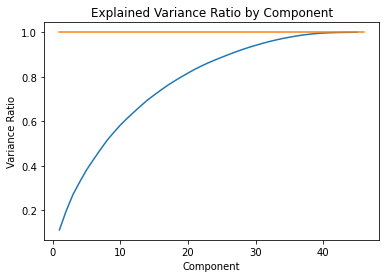

In [37]:
#Plots for the explained variance ratios of the features

#1. Train Set
explained_variance_ratio_cumul_sum=np.cumsum(pca1.explained_variance_ratio_) #compute the cumulative sum
explained_variance_ratio_cumul_sum
plt.title("Explained Variance Ratio by Component")
plt.plot(np.arange(1,46),explained_variance_ratio_cumul_sum) #so that the first component is at 1, not 0
plt.plot([1,46],[1,1])
plt.xlabel("Component")
plt.ylabel("Variance Ratio")
plt.show()

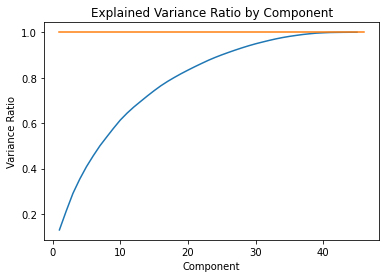

In [38]:
#2. Validation Set
explained_variance_ratio_cumul_sum=np.cumsum(pca2.explained_variance_ratio_) #compute the cumulative sum
explained_variance_ratio_cumul_sum
plt.title("Explained Variance Ratio by Component")
plt.plot(np.arange(1,46),explained_variance_ratio_cumul_sum) #so that the first component is at 1, not 0
plt.plot([1,46],[1,1])
plt.xlabel("Component")
plt.ylabel("Variance Ratio")
plt.show()

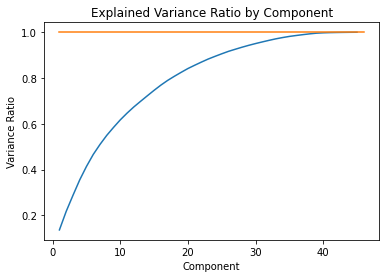

In [39]:
#3. Test Set
explained_variance_ratio_cumul_sum=np.cumsum(pca3.explained_variance_ratio_) #compute the cumulative sum
explained_variance_ratio_cumul_sum
plt.title("Explained Variance Ratio by Component")
plt.plot(np.arange(1,46),explained_variance_ratio_cumul_sum) #so that the first component is at 1, not 0
plt.plot([1,46],[1,1])
plt.xlabel("Component")
plt.ylabel("Variance Ratio")
plt.show()

In [40]:
#The ideal number of features explaining nearly 100% of the variance is nearly 40 in the train, validation and testing datasets 
#respectively. Therefore excluding 6 features mentioned on the dataset (apart from Attrition_Yes) will be based on the 
#least variance loss

#1. Train set
pca1.explained_variance_

array([0.58718262, 0.44367776, 0.38199491, 0.29510217, 0.27929444,
       0.2369787 , 0.22781484, 0.22078201, 0.18668416, 0.17799823,
       0.15592417, 0.14655093, 0.14290713, 0.13854675, 0.11890263,
       0.11597889, 0.1114941 , 0.10012434, 0.09574093, 0.0892695 ,
       0.08795322, 0.07926991, 0.07311656, 0.06686993, 0.0641138 ,
       0.06207097, 0.05987131, 0.05592096, 0.05269734, 0.04740438,
       0.04579466, 0.04210858, 0.03767756, 0.03511587, 0.02969921,
       0.02727499, 0.02470553, 0.01869817, 0.01629058, 0.01023426,
       0.00782767, 0.00456985, 0.00306703, 0.00205091, 0.00164542])

In [41]:
#2. Validation set
pca2.explained_variance_

array([6.92086020e-01, 4.38899822e-01, 4.15444925e-01, 3.32071790e-01,
       2.91981376e-01, 2.54024005e-01, 2.36366892e-01, 2.05674476e-01,
       2.02013901e-01, 1.91367575e-01, 1.61352137e-01, 1.43614651e-01,
       1.29785849e-01, 1.28966862e-01, 1.22702609e-01, 1.15398670e-01,
       1.02284149e-01, 9.28691995e-02, 8.79277722e-02, 8.20150124e-02,
       7.92742461e-02, 7.55977246e-02, 7.39020068e-02, 6.69986503e-02,
       6.13864618e-02, 5.72320507e-02, 5.50246113e-02, 5.22852798e-02,
       4.89344583e-02, 4.51325254e-02, 4.01412922e-02, 3.87870813e-02,
       3.57982562e-02, 3.15412964e-02, 2.70130347e-02, 2.28390648e-02,
       2.16032392e-02, 1.68889745e-02, 1.48116230e-02, 8.29343648e-03,
       6.42044613e-03, 2.66611794e-03, 2.01060492e-03, 1.32454941e-03,
       1.34543222e-32])

In [42]:
#3. Test set
pca3.explained_variance_

array([0.70633795, 0.41697476, 0.36154382, 0.34904733, 0.30377142,
       0.2698175 , 0.22632761, 0.204895  , 0.17912521, 0.17012793,
       0.15145696, 0.13969358, 0.12715289, 0.12498466, 0.12298205,
       0.11711562, 0.10603471, 0.09370324, 0.08874473, 0.08560041,
       0.07405565, 0.07153008, 0.0684859 , 0.0601841 , 0.05794157,
       0.05539222, 0.04703254, 0.04609269, 0.04283622, 0.03957323,
       0.03694957, 0.03578986, 0.03365337, 0.02885606, 0.0257409 ,
       0.02053147, 0.01939833, 0.01787878, 0.01503839, 0.00826157,
       0.00470614, 0.0029497 , 0.00232987, 0.00179875, 0.00112089])

The least variance cells (6 in number), as observed in the explained variances array above for all the three datasets have been removed. Further, another set of datasets have been refined i.e. the reduced dimensions datasets have been refined by removing the columns which had missing values in the original dataset (the one shared by Nikitha) since imputations had been done in a subjective manner.

In [43]:
#Dropping the least variance cells

#1. Train Set
prev_cl_train7 = prev_cl_train6.drop(["MaritalStatus_Married","MaritalStatus_Single","OverTime_Yes","currentrole_tenure_percentage","company_tenure_percentage","manager_tenure_percentage"], axis = 1)

#As an alternative, we will update prev_cl_train7 by excluding the coluns with missing value
prev_cl_train8 = prev_cl_train7.drop(["Age", "DailyRate", "BusinessTravel_Travel_Frequently", "BusinessTravel_Travel_Rarely","DistanceFromHome"], axis = 1)

In [44]:
#2. Validation Set
prev_cl_val7 = prev_cl_val6.drop(["MaritalStatus_Married","MaritalStatus_Single","OverTime_Yes","currentrole_tenure_percentage","company_tenure_percentage","manager_tenure_percentage"], axis = 1)

#As an alternative, we will update prev_cl_val7 by excluding the coluns with missing value
prev_cl_val8 = prev_cl_val7.drop(["Age", "DailyRate", "BusinessTravel_Travel_Frequently", "BusinessTravel_Travel_Rarely","DistanceFromHome"], axis = 1)

In [45]:
#3. Test Set
prev_cl_test7 = prev_cl_test6.drop(["MaritalStatus_Married","MaritalStatus_Single","OverTime_Yes","currentrole_tenure_percentage","company_tenure_percentage","manager_tenure_percentage"], axis = 1)

#As an alternative, we will update prev_cl_test7 by excluding the coluns with missing value
prev_cl_test8 = prev_cl_test7.drop(["Age", "DailyRate", "BusinessTravel_Travel_Frequently", "BusinessTravel_Travel_Rarely","DistanceFromHome"], axis = 1)

With all the alternate datasets ready for the each of the training, validation and testing datasets, we can now proceed to run predictive models on them using Hyperparameter tuning and random forest classifier. We have used the solely normalised training, validation and testing datasets since they have better results in comparison to the other two alternatives.

#### Hence, the important inputs in determining wherther an employee will accept an RCC or not are all the 44 features given on the normalised training, validation and testing datasets

## 2. Predictive Models for determining probabilities of attrition

### 2.1 Hyperparameter Tuning (using multinomial logistic regression)

In [46]:
#Defining the dependent and independent variables

y_train = prev_cl_train6["Attrition_Yes"] #creating the dependent variable
x_train = prev_cl_train6.drop(columns=["Attrition_Yes"]) #dropping the dependent variable to get a matrix of independent features

In [47]:
#We fit the model using sklearn on the training data

logm = LogisticRegression()
logm.fit(x_train, y_train.values.ravel()) # Fit a logistic regression with vector Y as dependent and matrix X as independent
print(logm.intercept_)

[-1.12901904]


In [48]:
print(logm.coef_)

[[-6.76016054e-01 -4.38506691e-01  7.36721444e-01  2.16786443e-01
  -9.49865835e-01 -2.13700873e-02 -1.19100988e+00 -5.96608308e-01
  -1.02172418e+00 -9.93779870e-02  3.02235689e-01  1.30016756e+00
   6.04523540e-01 -5.92717275e-01 -3.65119129e-01 -6.20892013e-01
  -4.37036011e-01 -9.42863220e-01 -7.19018037e-01  1.04619077e+00
   1.17040720e+00  9.12015825e-01 -3.33655475e-01  5.70692012e-01
  -5.79059533e-01  4.92572792e-02 -1.15962321e-01 -2.03515475e-01
   7.91122662e-01  6.99416947e-01  1.01956215e-01  1.11405828e+00
  -1.41321040e-01  1.26413767e-03 -1.78299135e-02  2.99976546e-01
   1.20957767e-02  3.62728040e-01  2.71649952e-01  1.35357935e+00
   1.26649245e+00 -8.00233676e-01  6.58317776e-01 -1.08231952e+00]]


In [49]:
#Now, we get the prediction probabilities on the validation dataset

x_val = prev_cl_val6.drop(columns=["Attrition_Yes"])
y_val = prev_cl_val6["Attrition_Yes"]
logm.predict_proba(x_val)

array([[0.98131362, 0.01868638],
       [0.47693716, 0.52306284],
       [0.85514067, 0.14485933],
       [0.48437181, 0.51562819],
       [0.25836048, 0.74163952],
       [0.96633935, 0.03366065],
       [0.8604594 , 0.1395406 ],
       [0.93295961, 0.06704039],
       [0.44665588, 0.55334412],
       [0.74827494, 0.25172506],
       [0.70517614, 0.29482386],
       [0.70721147, 0.29278853],
       [0.89455368, 0.10544632],
       [0.97353267, 0.02646733],
       [0.9803198 , 0.0196802 ],
       [0.890872  , 0.109128  ],
       [0.95720848, 0.04279152],
       [0.50570345, 0.49429655],
       [0.96059756, 0.03940244],
       [0.95507226, 0.04492774],
       [0.74623862, 0.25376138],
       [0.87111567, 0.12888433],
       [0.92666663, 0.07333337],
       [0.82222595, 0.17777405],
       [0.91748372, 0.08251628],
       [0.98594914, 0.01405086],
       [0.67809899, 0.32190101],
       [0.86671663, 0.13328337],
       [0.99316514, 0.00683486],
       [0.01368465, 0.98631535],
       [0.

In [50]:
#However, we only care about one side (the probability of having "1", that is, of leaving).

y_val_probs=logm.predict_proba(x_val)[:,1]
y_val_probs

array([0.01868638, 0.52306284, 0.14485933, 0.51562819, 0.74163952,
       0.03366065, 0.1395406 , 0.06704039, 0.55334412, 0.25172506,
       0.29482386, 0.29278853, 0.10544632, 0.02646733, 0.0196802 ,
       0.109128  , 0.04279152, 0.49429655, 0.03940244, 0.04492774,
       0.25376138, 0.12888433, 0.07333337, 0.17777405, 0.08251628,
       0.01405086, 0.32190101, 0.13328337, 0.00683486, 0.98631535,
       0.23181208, 0.03313363, 0.12830045, 0.3491689 , 0.25854186,
       0.01411354, 0.05058839, 0.09607741, 0.25152426, 0.07740097,
       0.36846075, 0.08263053, 0.40209969, 0.03454071, 0.37956783,
       0.26786798, 0.36898501, 0.01986716, 0.00884664, 0.0224388 ,
       0.24605856, 0.27811337, 0.11446743, 0.07728644, 0.47831769,
       0.14946675, 0.06006805, 0.22998338, 0.2310124 , 0.1101204 ,
       0.52854697, 0.19592101, 0.72543421, 0.09546658, 0.01466328,
       0.1945383 , 0.2380739 , 0.08897605, 0.12825719, 0.03125671,
       0.05284107, 0.03686787, 0.2816405 , 0.14900009, 0.09577

We test the model fitness on the validation set using a combination of measures such as AUC (area under the ROC curve), confusion matrix (along with accuracy score) and the mean squared error. 

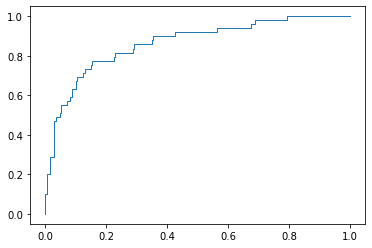

In [52]:
#We can now test the fitness of the model using a ROC curve

fpr, tpr, thresholds = metrics.roc_curve(y_val,y_val_probs)
plt.plot(fpr, tpr, linewidth=1)
plt.show()

In [53]:
#The AUC summarizes the quality of our model by measuring (roughly) how close we can get to a perfect model

roc_auc_score(y_val,y_val_probs)

0.8653451811346548

In [54]:
#Now, we need to choose a threshold. A natural threshold to choose is 0.1355

chosen_threshold = np.min(thresholds[thresholds > 0.1355])
print(chosen_threshold)
threshold_idx = np.where(thresholds == chosen_threshold)[0][0]
print(threshold_idx)

0.14900009120750288
40


In [55]:
#The FPR and TPR at this threshold is:

print("At threshold  " + str(thresholds[threshold_idx]))
print("the false positive rate is " + str(fpr[threshold_idx]))
print("and the true positive rate is " + str(tpr[threshold_idx]))

At threshold  0.14900009120750288
the false positive rate is 0.291866028708134
and the true positive rate is 0.8571428571428571


In [58]:
#With a choice of thresholds, we can now make predictions of leaving (on the validation set) and display the confusion matrix:

y_val_pred = np.where(y_val_probs > chosen_threshold, 1, 0)
y_val_pred

array([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0])

In [59]:
cm_val = confusion_matrix(y_val,y_val_pred)
print(cm_val)
print(accuracy_score(y_val,y_val_pred))

[[148  61]
 [  8  41]]
0.7325581395348837


In [60]:
#Calculation of the mean square error of the validation set

mean_squared_error(y_val, y_val_pred)

0.26744186046511625

We further retrain the final model using a combination of both the training and validation sets on the testing set 

In [61]:
#Now, retraining the final model with training + validation, and testing the same

x_train_final=pd.concat([x_train, x_val])
y_train_final=pd.concat([y_train, y_val])

In [62]:
logm_test = LogisticRegression().fit(x_train_final, y_train_final.values.ravel())

In [64]:
x_test = prev_cl_test6.drop(columns=["Attrition_Yes"])
y_test = prev_cl_test6["Attrition_Yes"]

y_test_probs=logm_test.predict_proba(x_test)[:,1]
threshold = 0.1355
y_test_pred=np.where(y_test_probs > threshold, 1, 0) #predict the classes for test dataset based on the threshold found via the validation data

In [65]:
#Printing confusion matrix and accuracy score

print(confusion_matrix(y_test,y_test_pred))
print(accuracy_score(y_test,y_test_pred))

[[152  69]
 [ 10  26]]
0.6926070038910506


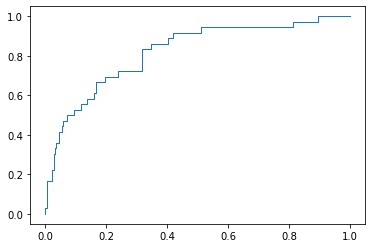

In [66]:
#We can now test the fitness of the test model using a ROC curve

fpr, tpr, thresholds = metrics.roc_curve(y_test,y_test_probs)
plt.plot(fpr, tpr, linewidth=1)
plt.show()

In [67]:
#The AUC summarizes the quality of our test model by measuring (roughly) how close we can get to a perfect model

roc_auc_score(y_test,y_test_probs)

0.8213926596279537

In [68]:
mean_squared_error(y_test, y_test_pred)

0.30739299610894943

We observe that the model inputs fit well onto both the validation and testing datasets since we observe a relatively high AUC score, high accuracy score and low mean squared error. 
#### This further reaffirms our statement made above that all the 44 input features are important in determining whether an employee will accept an RCC or not

We can now move onto the second method of prediction i.e. random classifier.

### 2.2 Random Forest Classifier method of prediction

In [69]:
Y_train_rfc=prev_cl_train6[["Attrition_Yes"]]
X_train_rfc=prev_cl_train6.drop(columns="Attrition_Yes")
Y_test_rfc=prev_cl_test6[["Attrition_Yes"]]
X_test_rfc=prev_cl_test6.drop(columns="Attrition_Yes")

In [70]:
#Creation of the model for random forest classification purposes

clf = RandomForestClassifier()
clf.fit(X_train_rfc, Y_train_rfc)

C:\Users\user\AppData\Local\Temp\ipykernel_8348\821352213.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train_rfc, Y_train_rfc)


RandomForestClassifier()

In [71]:
Y_pred_rfc = clf.predict(X_test_rfc)
Y_pred_rfc

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0.

In [72]:
#Evaluating the model using accuracy score and confusion matrix

print(accuracy_score(Y_test_rfc,Y_pred_rfc))
print(confusion_matrix(Y_test_rfc,Y_pred_rfc))

0.8599221789883269
[[218   3]
 [ 33   3]]


In terms of model fitness, both the prediction model deliver similarly fit results. Hence in order to predict the probability of employees leaving from the Lyon office, we will use the logistic regression predictive model used in Hyperparameter tuning.

## 3. Pre-processing Lyon Office's data (similar pre-processing as done with previous closure dataset and generating probabilities of employees leaving

In [75]:
#Importing Dataset

ly_data = pd.read_csv("employee_attrition_lyon.csv")
ly_data

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,NaN,Travel_Rarely,866.0,Sales,NaN,3,Medical,1,1469,4,...,4,80,0,6,4,3,5,4,1,3
1,53.0,Travel_Rarely,1084.0,Research & Development,13.0,2,Medical,1,250,4,...,3,80,2,5,3,3,4,2,1,3
2,24.0,Travel_Rarely,240.0,Human Resources,22.0,1,Human Resources,1,1714,4,...,3,80,1,1,2,3,1,0,0,0
3,45.0,Travel_Rarely,1339.0,Research & Development,7.0,3,Life Sciences,1,86,2,...,3,80,1,25,2,3,1,0,0,0
4,36.0,Travel_Rarely,1396.0,Research & Development,NaN,2,Life Sciences,1,304,4,...,4,80,0,16,3,4,13,11,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,33.0,Travel_Frequently,430.0,Sales,7.0,3,Medical,1,1477,4,...,1,80,2,5,2,3,4,3,0,3
437,27.0,Non-Travel,210.0,Sales,1.0,1,Marketing,1,449,3,...,4,80,1,6,0,3,5,4,1,4
438,NaN,Travel_Rarely,1157.0,Research & Development,2.0,4,Medical,1,440,1,...,4,80,0,5,4,2,3,2,2,2
439,39.0,Travel_Rarely,1383.0,Human Resources,2.0,3,Life Sciences,1,909,4,...,3,80,2,13,2,3,5,4,0,4


In [76]:
#Checking for any duplicate values
ly_data_dups = ly_data.duplicated()
print(ly_data_dups.any())

False


In [77]:
#Drop columns with a single value for all rows due to no informative value
ly_data.nunique()

Age                          39
BusinessTravel                3
DailyRate                   368
Department                    3
DistanceFromHome             27
Education                     5
EducationField                6
EmployeeCount                 1
EmployeeNumber              441
EnvironmentSatisfaction       4
Gender                        2
HourlyRate                   71
JobInvolvement                4
JobLevel                      5
JobRole                       9
JobSatisfaction               4
MaritalStatus                 3
MonthlyIncome               430
MonthlyRate                 437
NumCompaniesWorked           10
Over18                        1
OverTime                      2
PercentSalaryHike            15
PerformanceRating             2
RelationshipSatisfaction      4
StandardHours                 1
StockOptionLevel              4
TotalWorkingYears            37
TrainingTimesLastYear         7
WorkLifeBalance               4
YearsAtCompany               34
YearsInC

In [78]:
ly_data2 = ly_data.drop(["EmployeeCount","Over18","StandardHours","EmployeeNumber"], axis = 1)#Removing employee number as well due to no informative value
ly_data2

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,NaN,Travel_Rarely,866.0,Sales,NaN,3,Medical,4,Male,84,...,3,4,0,6,4,3,5,4,1,3
1,53.0,Travel_Rarely,1084.0,Research & Development,13.0,2,Medical,4,Female,57,...,3,3,2,5,3,3,4,2,1,3
2,24.0,Travel_Rarely,240.0,Human Resources,22.0,1,Human Resources,4,Male,58,...,3,3,1,1,2,3,1,0,0,0
3,45.0,Travel_Rarely,1339.0,Research & Development,7.0,3,Life Sciences,2,Male,59,...,3,3,1,25,2,3,1,0,0,0
4,36.0,Travel_Rarely,1396.0,Research & Development,NaN,2,Life Sciences,4,Male,62,...,3,4,0,16,3,4,13,11,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,33.0,Travel_Frequently,430.0,Sales,7.0,3,Medical,4,Male,54,...,3,1,2,5,2,3,4,3,0,3
437,27.0,Non-Travel,210.0,Sales,1.0,1,Marketing,3,Male,73,...,3,4,1,6,0,3,5,4,1,4
438,NaN,Travel_Rarely,1157.0,Research & Development,2.0,4,Medical,1,Male,84,...,3,4,0,5,4,2,3,2,2,2
439,39.0,Travel_Rarely,1383.0,Human Resources,2.0,3,Life Sciences,4,Female,42,...,3,3,2,13,2,3,5,4,0,4


In [79]:
#Checking for missing values

ly_data2.isna().sum()

Age                         55
BusinessTravel               5
DailyRate                   14
Department                   0
DistanceFromHome            54
Education                    0
EducationField               0
EnvironmentSatisfaction      0
Gender                       0
HourlyRate                   0
JobInvolvement               0
JobLevel                     0
JobRole                      0
JobSatisfaction              0
MaritalStatus                3
MonthlyIncome                0
MonthlyRate                  0
NumCompaniesWorked           0
OverTime                     0
PercentSalaryHike            0
PerformanceRating            0
RelationshipSatisfaction     0
StockOptionLevel             0
TotalWorkingYears            0
TrainingTimesLastYear        0
WorkLifeBalance              0
YearsAtCompany               0
YearsInCurrentRole           0
YearsSinceLastPromotion      0
YearsWithCurrManager         0
dtype: int64

In [80]:
#Imputation of missing values using relevant methods, as given below:

#For 'Age' we use a nearest row value approach
imputer = KNNImputer(n_neighbors=1)
ly_data2[["Age"]] = imputer.fit_transform(ly_data2[["Age"]])

#For 'Business Travel' and 'Marital Status'(Only Train set), we use the most frequest values to impute the missing ones
imp=SimpleImputer(missing_values=np.nan, strategy="most_frequent")
ly_data2[["BusinessTravel","MaritalStatus"]]=imp.fit_transform(ly_data2[["BusinessTravel","MaritalStatus"]])


#For 'Daily Rate' and 'Distance from Home' filling missing values using the average of other rows
imp=SimpleImputer(missing_values=np.nan, strategy="mean")
ly_data2[["DailyRate","DistanceFromHome"]]=imp.fit_transform(ly_data2[["DailyRate","DistanceFromHome"]])

In [81]:
#Converting categorical variables into Numerical Variables (one hot encoding) for the purpose of normalising the data
ly_data3 = pd.get_dummies(ly_data2, drop_first = True)

In [82]:
#Adding and removing features for all the three datasets (features added from an more informative variable point of view)

##Adding a new feature combining years in current roles and years in the company to get proportion of time spent on the current role, and drop years in current role
ly_data3["currentrole_tenure_percentage"]=ly_data3["YearsInCurrentRole"]/ly_data3["YearsAtCompany"]

##Adding a feature to check proportion of time spent at current company in comparison with total working years
ly_data3["company_tenure_percentage"]=ly_data3["YearsAtCompany"]/ly_data3["TotalWorkingYears"]

##Adding a feature to check to proportion of total time in the company spent with the current manager
ly_data3["manager_tenure_percentage"]=ly_data3["YearsWithCurrManager"]/ly_data3["YearsAtCompany"]

##Drop total working years, years in current role and years with current manager from the dataset (keeping years in company since that might be a effective determinant of RCC acceptance due to it being used as a base to decide severance packages)
ly_data4 = ly_data3.drop(["TotalWorkingYears", "YearsInCurrentRole", "YearsWithCurrManager"], axis = 1)

In [83]:
#Checking for any missing values in the update dataframe

ly_data4.isna().sum()

Age                                   0
DailyRate                             0
DistanceFromHome                      0
Education                             0
EnvironmentSatisfaction               0
HourlyRate                            0
JobInvolvement                        0
JobLevel                              0
JobSatisfaction                       0
MonthlyIncome                         0
MonthlyRate                           0
NumCompaniesWorked                    0
PercentSalaryHike                     0
PerformanceRating                     0
RelationshipSatisfaction              0
StockOptionLevel                      0
TrainingTimesLastYear                 0
WorkLifeBalance                       0
YearsAtCompany                        0
YearsSinceLastPromotion               0
BusinessTravel_Travel_Frequently      0
BusinessTravel_Travel_Rarely          0
Department_Research & Development     0
Department_Sales                      0
EducationField_Life Sciences          0


In [84]:
#Missing values (NaN) were present due to zeroes being present on either of the columns used for adding features

ly_data5 = ly_data4.fillna(0)

In [85]:
#Normalizing the dataset

ly_scaler = MinMaxScaler()
ly_scaler.fit(ly_data5)
ly_scaled = ly_scaler.fit_transform(ly_data5)
ly_data6 = pd.DataFrame(ly_scaled, columns = ly_data5.columns)

In [86]:
ly_data6

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,currentrole_tenure_percentage,company_tenure_percentage,manager_tenure_percentage
0,0.476190,0.546237,0.302141,0.50,1.000000,0.771429,0.666667,0.25,0.000000,0.396597,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.800000,0.833333,0.600000
1,0.833333,0.702509,0.428571,0.25,1.000000,0.385714,1.000000,0.25,0.000000,0.181872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.800000,0.750000
2,0.142857,0.097491,0.750000,0.00,1.000000,0.400000,0.000000,0.00,0.666667,0.026968,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,1.000000,0.000000
3,0.642857,0.885305,0.214286,0.50,0.333333,0.414286,0.666667,0.50,0.000000,0.464070,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.040000,0.000000
4,0.428571,0.926165,0.302141,0.25,1.000000,0.457143,0.666667,0.25,0.333333,0.260207,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.846154,0.812500,0.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,0.357143,0.233692,0.214286,0.50,1.000000,0.342857,0.666667,0.25,0.000000,0.177752,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.750000,0.800000,0.750000
437,0.214286,0.075986,0.000000,0.00,0.666667,0.614286,0.666667,0.25,0.333333,0.283482,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.800000,0.833333,0.800000
438,0.476190,0.754839,0.035714,0.75,0.000000,0.771429,0.000000,0.00,1.000000,0.129113,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.666667,0.600000,0.666667
439,0.500000,0.916846,0.035714,0.50,1.000000,0.171429,0.333333,0.25,1.000000,0.222216,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.800000,0.384615,0.800000


In [90]:
#Calculation of probabilities for Lyon office employees on leaving the company

x_ly_final = ly_data6 #Using the normalized dataset

In [107]:
#Using results from Hyperparameter tuning to derive the probabilities

y_ly_final = logm.predict_proba(x_ly_final)[:,1]#Using the logistic regression model
y_ly_final

array([0.20417411, 0.00528868, 0.33235709, 0.06810546, 0.18847233,
       0.29981176, 0.38280759, 0.03811003, 0.09283949, 0.02265606,
       0.29549835, 0.13414726, 0.21264444, 0.02638298, 0.03384405,
       0.21838246, 0.11165746, 0.24459134, 0.08543183, 0.13557172,
       0.45232489, 0.00752749, 0.05673915, 0.27856167, 0.06810785,
       0.0523245 , 0.12959792, 0.05694697, 0.13320307, 0.06464181,
       0.02108405, 0.00825099, 0.00655413, 0.07899499, 0.24801399,
       0.0159261 , 0.0053608 , 0.33867319, 0.65390658, 0.02404594,
       0.07470527, 0.22188604, 0.09734062, 0.02767466, 0.73556443,
       0.0147557 , 0.78249783, 0.54228171, 0.42127734, 0.40565832,
       0.0430542 , 0.18882885, 0.10880978, 0.18961996, 0.14418588,
       0.05906621, 0.27353494, 0.00356615, 0.07406858, 0.12262994,
       0.01786056, 0.64291282, 0.02568023, 0.01051222, 0.42460868,
       0.208407  , 0.05766172, 0.12310984, 0.01461437, 0.20069732,
       0.2522619 , 0.1268989 , 0.36425963, 0.40233566, 0.06767

In [95]:
y_ly_final_pred = np.where(y_ly_final < 0.18, 0, 1) #where 0 means stay and 1 means leave
y_ly_final_pred

array([1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [96]:
print(*y_ly_final_pred, sep = " ")

1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1


In [124]:
#Dataframe with the listed probabilities of leaving and binary variable indicating whether the respective employee will leave(1)
#or not(0)

ly_data_final = pd.DataFrame(y_ly_final)
ly_data_final["probability"] = pd.DataFrame(y_ly_final)
ly_data_final['ID'] = ly_data_final.index + 1
ly_data_final['Leave'] = y_ly_final_pred
ly_data_final

,0,probability,ID,Leave
0,0.204174,0.204174,1,1
1,0.005289,0.005289,2,0
2,0.332357,0.332357,3,1
3,0.068105,0.068105,4,0
4,0.188472,0.188472,5,1
...,...,...,...,...
436,0.087424,0.087424,437,0
437,0.095824,0.095824,438,0
438,0.424216,0.424216,439,1
439,0.005936,0.005936,440,0


## 4. Devising employee categories

Now, since we have the probabilities of leaving for all the employees, we can proceed with devising the categories of Lyon office employees who can be offered an RCC to. For the same purpose, we will only consider the employees which value a value of Leave = '1', and thereafter draw plots of each of the inputs/features against the probability of leaving to find any patterns helpful in determining the categories.

In [114]:
#Probability of employees leaving the company (only this to be considered)

ly_data_final_leave = ly_data_final[ly_data_final['Leave']==1].sort_values(by = 'probability')
ly_data_final_leave

,0,probability,ID,Leave
269,0.180587,0.180587,270,1
137,0.186141,0.186141,138,1
286,0.186394,0.186394,287,1
4,0.188472,0.188472,5,1
51,0.188829,0.188829,52,1
...,...,...,...,...
242,0.742952,0.742952,243,1
111,0.771008,0.771008,112,1
46,0.782498,0.782498,47,1
234,0.833452,0.833452,235,1


In [116]:
#Probability of employees staying in the company (only for reference purposes)

ly_data_final_stay = ly_data_final[ly_data_final['Leave']==0].sort_values(by = 'probability')
ly_data_final_stay

,0,probability,ID,Leave
80,0.001303,0.001303,81,0
358,0.001800,0.001800,359,0
190,0.003034,0.003034,191,0
236,0.003521,0.003521,237,0
57,0.003566,0.003566,58,0
...,...,...,...,...
132,0.167852,0.167852,133,0
163,0.170887,0.170887,164,0
100,0.173521,0.173521,101,0
98,0.174355,0.174355,99,0


Now we merge the probability of employees leaving dataframe ("ly_data_final_leave") with the normalized dataframe ("ly_data6) containing all the features

In [117]:
#Merging the prob. of employees leaving dataframe with the original dataframe containing all the features
##Further the final dataframe has been arranged with the probability column being arranged in a descending order

merged_leave = pd.merge(ly_data_final_leave,ly_data6, left_index = True, right_index = True) #merging both the dataframes
merged_leave2 = merged_leave.drop(merged_leave.columns[[0,3]], axis=1) #deleting redundant columns of duplicate probability values
merged_leave3 = merged_leave2.sort_values('probability', ascending = False, ignore_index = True) #Sorting the probability column in a descending order
merged_leave3

,probability,ID,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,currentrole_tenure_percentage,company_tenure_percentage,manager_tenure_percentage
0,0.901632,224,0.261905,0.007885,0.428571,0.50,0.000000,0.300000,0.666667,0.25,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.600000,0.714286,0.000000
1,0.833452,235,0.571429,0.060215,1.000000,0.50,0.333333,0.371429,0.000000,0.25,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.062500,0.000000
2,0.782498,47,0.523810,0.139785,0.857143,0.75,1.000000,0.385714,0.333333,0.50,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.800000,0.555556,0.000000
3,0.771008,112,0.642857,0.653047,0.302141,1.00,0.666667,0.285714,0.000000,0.25,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.700000,1.000000,0.400000
4,0.742952,243,0.476190,0.746953,0.250000,0.50,1.000000,0.114286,0.333333,0.25,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.750000,0.666667,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0.188829,52,0.309524,0.420789,0.302141,0.75,0.666667,0.800000,0.666667,0.00,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.400000,0.833333,0.600000
132,0.188472,5,0.428571,0.926165,0.302141,0.25,1.000000,0.457143,0.666667,0.25,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.846154,0.812500,0.538462
133,0.186394,287,0.476190,0.260215,0.214286,0.50,0.666667,0.357143,0.666667,0.25,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.500000,0.800000,0.750000
134,0.186141,138,0.309524,0.308244,0.678571,0.50,0.000000,0.514286,0.666667,0.50,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.083333,0.000000


Next, we shall work on devising the categories of employees to be targeted for attrition purposes through visual data analysis

Firstly, we have divided the inputs/features into dummies and non-dummy variables since as observed, the dummy variables mainly consist of variables which may need to be taken extra care of since they might amount to discrimination in terms of job roles or a particular gender being targeted etc. whereas the non-dummies do not carry such a risk. Hence, for visual convenience, we have divided them into two parts and plot them accordingly against the probability of leaving.

The division between two parts also allows us to achieve the following objectives - 

1. For dummies, we aim to target the education fields, job roles etc. wherein the probability of leaving is the lowest since we would want to avoid a mass exodus at any job role or talent education pool.


2. For non-dummies, we aim to target the variables which follow a 'higher the variable, higher the probability of employees leaving the company'. This has been selected at random since the number of such variables were few in number whereas the opposite i.e. 'lower the variable, higher the probability of leaving' was higher. Hence, to avoid fine graining the categories to a huge extent, we have considered the former. This would help us in balancing out the lower probability measure considered in 1 above and also achieve the desired targets of salary cuts and minimised severance costs in an objective manner.


3. Post selecting the variables to be targeted, we use a combination of both 1 and 2 to build employee categories

#### For interpretation of the graphs given below and combinations used to build employee categories, refer to the PDF (Section A)

#### *We have not considered 'DailyRate', 'MonthlyRate' and 'HourlyRate' since they do not have any correlation with monthly income

<AxesSubplot:xlabel='manager_tenure_percentage', ylabel='probability'>

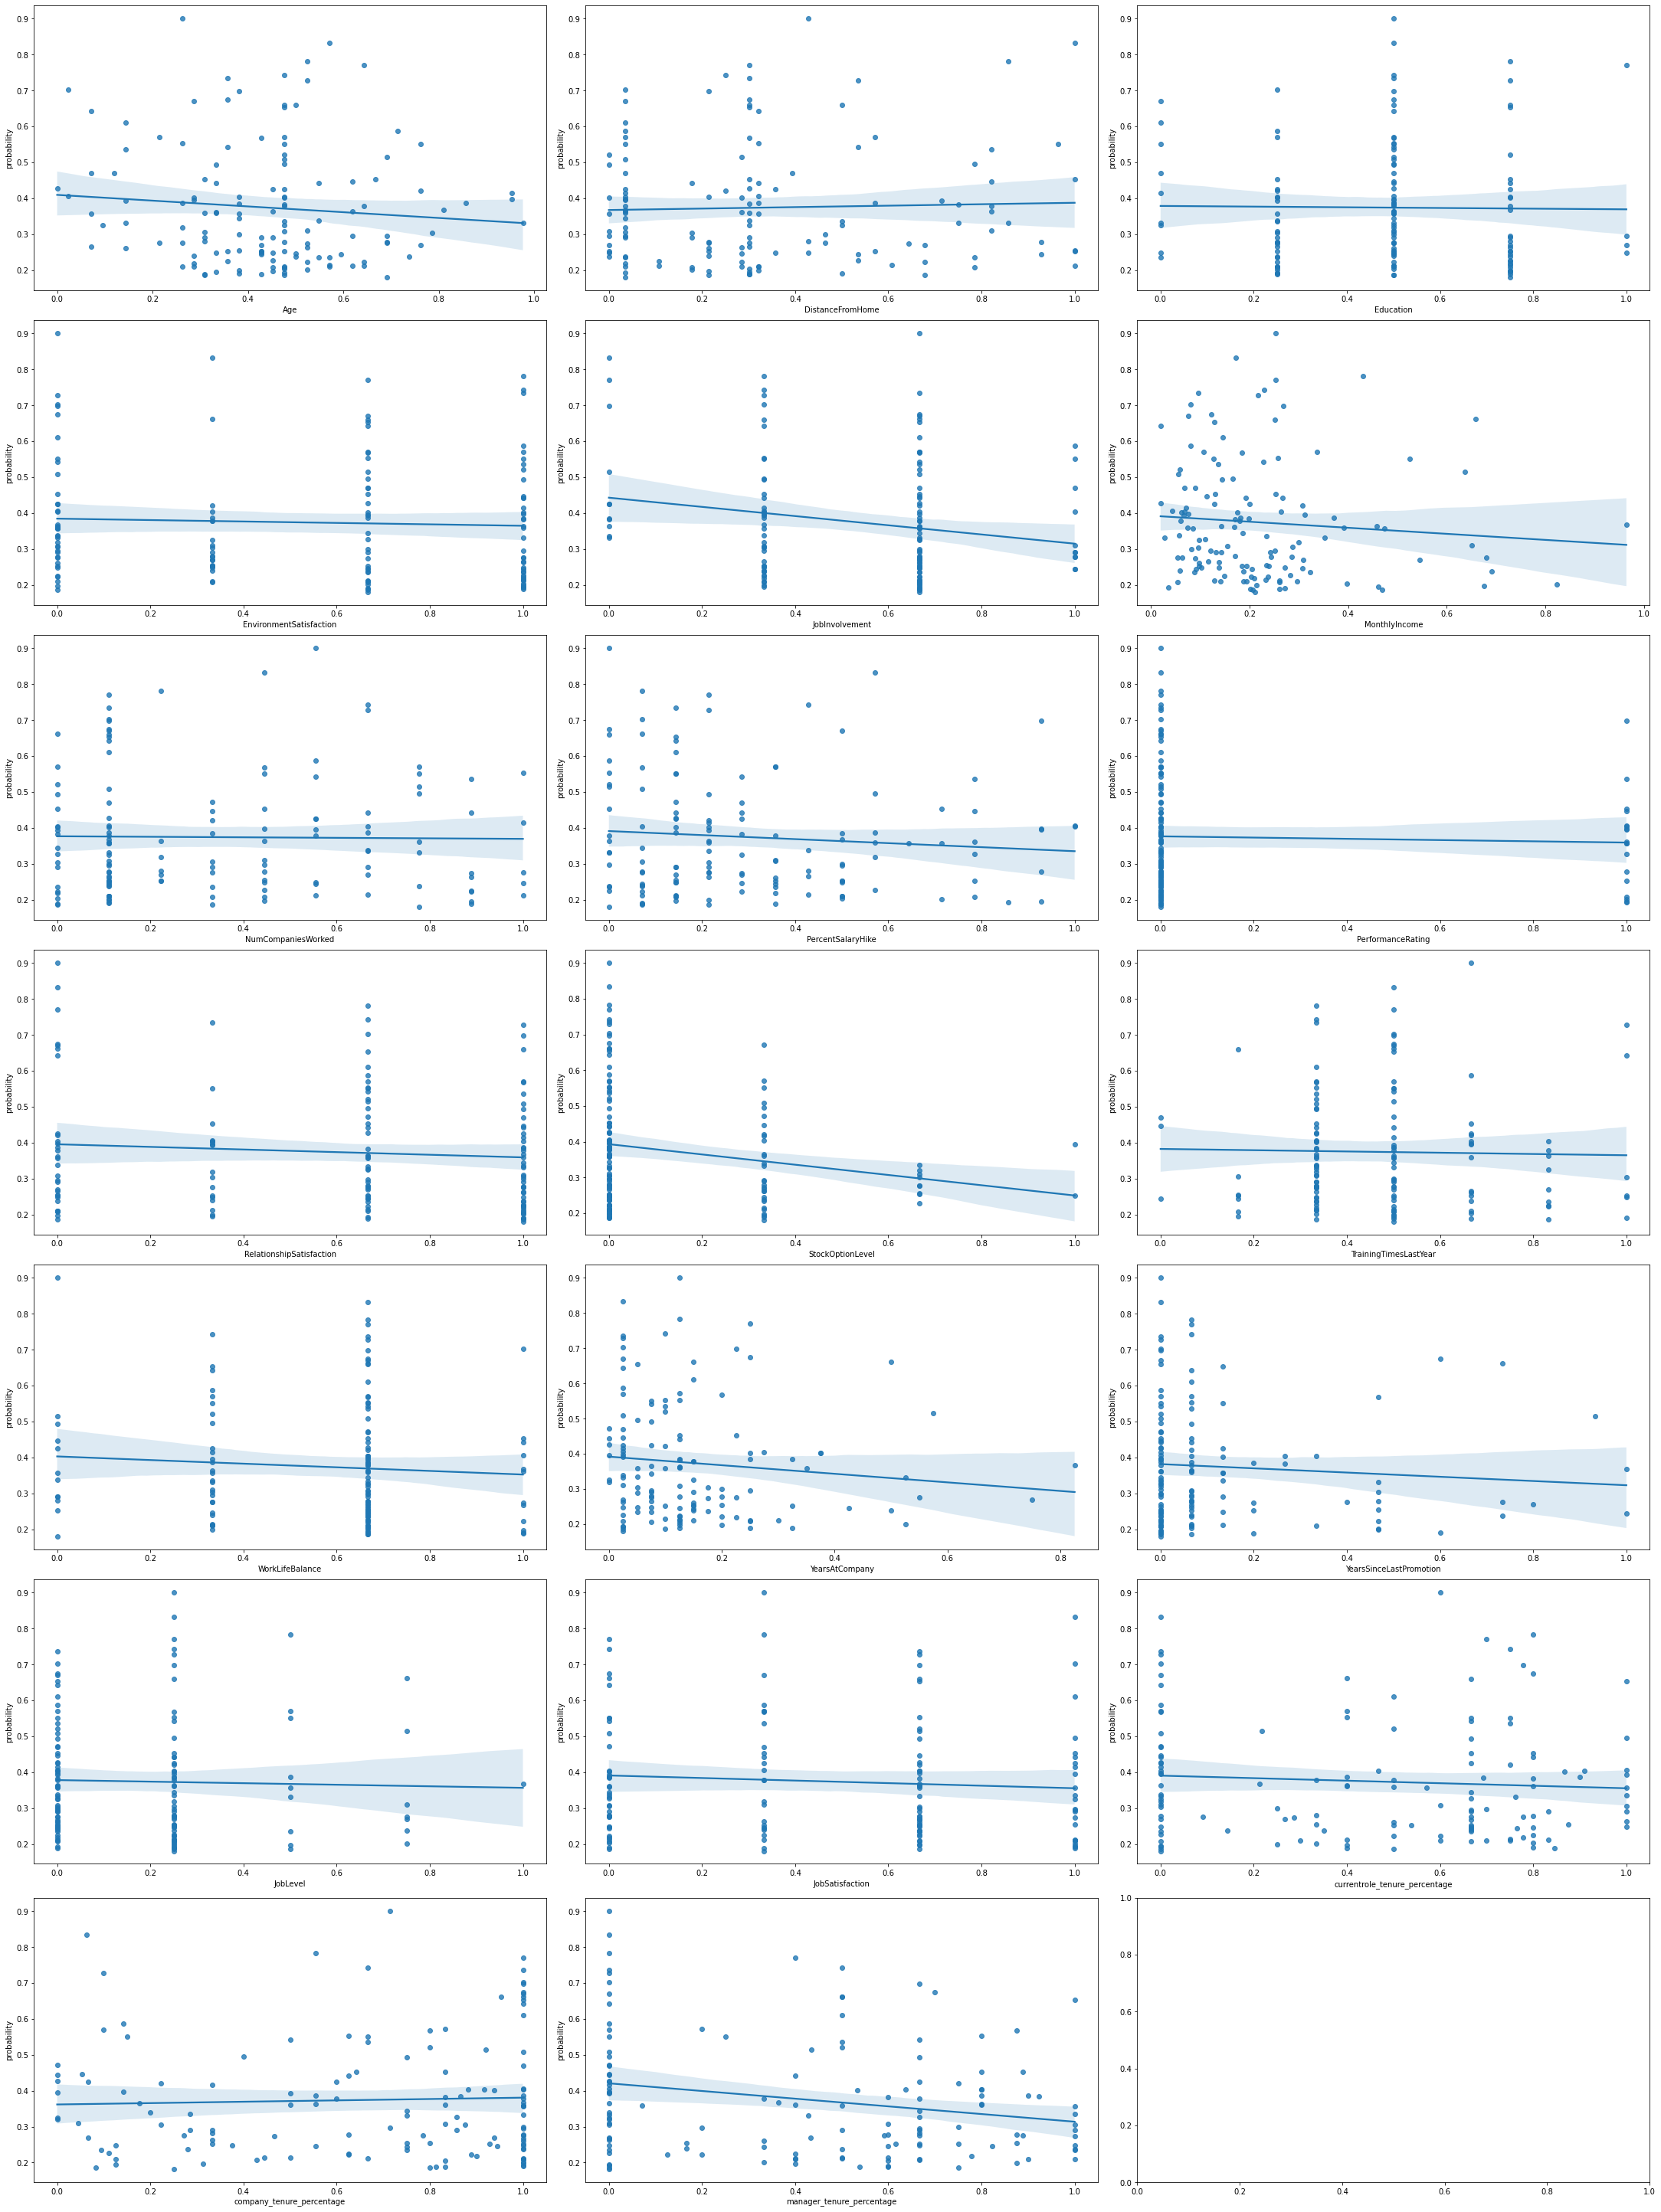

In [122]:
#Firstly, plotting the non-dummy variables

fig,axs = plt.subplots(nrows = 7, ncols=3, figsize = (30, 40), layout = "constrained")
sns.regplot(x='Age', y='probability', data=merged_leave3, ax=axs[0,0])
sns.regplot(x='DistanceFromHome', y='probability', data=merged_leave3, ax=axs[0,1])
sns.regplot(x='Education', y='probability', data=merged_leave3, ax=axs[0,2])
sns.regplot(x='EnvironmentSatisfaction', y='probability', data=merged_leave3, ax=axs[1,0])
sns.regplot(x='JobInvolvement', y='probability', data=merged_leave3, ax=axs[1,1])
sns.regplot(x='MonthlyIncome', y='probability', data=merged_leave3, ax=axs[1,2])
sns.regplot(x='NumCompaniesWorked', y='probability', data=merged_leave3, ax=axs[2,0])
sns.regplot(x='PercentSalaryHike', y='probability', data=merged_leave3, ax=axs[2,1])
sns.regplot(x='PerformanceRating', y='probability', data=merged_leave3, ax=axs[2,2])
sns.regplot(x='RelationshipSatisfaction', y='probability', data=merged_leave3, ax=axs[3,0])
sns.regplot(x='StockOptionLevel', y='probability', data=merged_leave3, ax=axs[3,1])
sns.regplot(x='TrainingTimesLastYear', y='probability', data=merged_leave3, ax=axs[3,2])
sns.regplot(x='WorkLifeBalance', y='probability', data=merged_leave3, ax=axs[4,0])
sns.regplot(x='YearsAtCompany', y='probability', data=merged_leave3, ax=axs[4,1])
sns.regplot(x='YearsSinceLastPromotion', y='probability', data=merged_leave3, ax=axs[4,2])
sns.regplot(x='JobLevel', y='probability', data=merged_leave3, ax=axs[5,0])
sns.regplot(x='JobSatisfaction', y='probability', data=merged_leave3, ax=axs[5,1])
sns.regplot(x='currentrole_tenure_percentage', y='probability', data=merged_leave3, ax=axs[5,2])
sns.regplot(x='company_tenure_percentage', y='probability', data=merged_leave3, ax=axs[6,0])
sns.regplot(x='manager_tenure_percentage', y='probability', data=merged_leave3, ax=axs[6,1])

<AxesSubplot:xlabel='OverTime_Yes', ylabel='probability'>

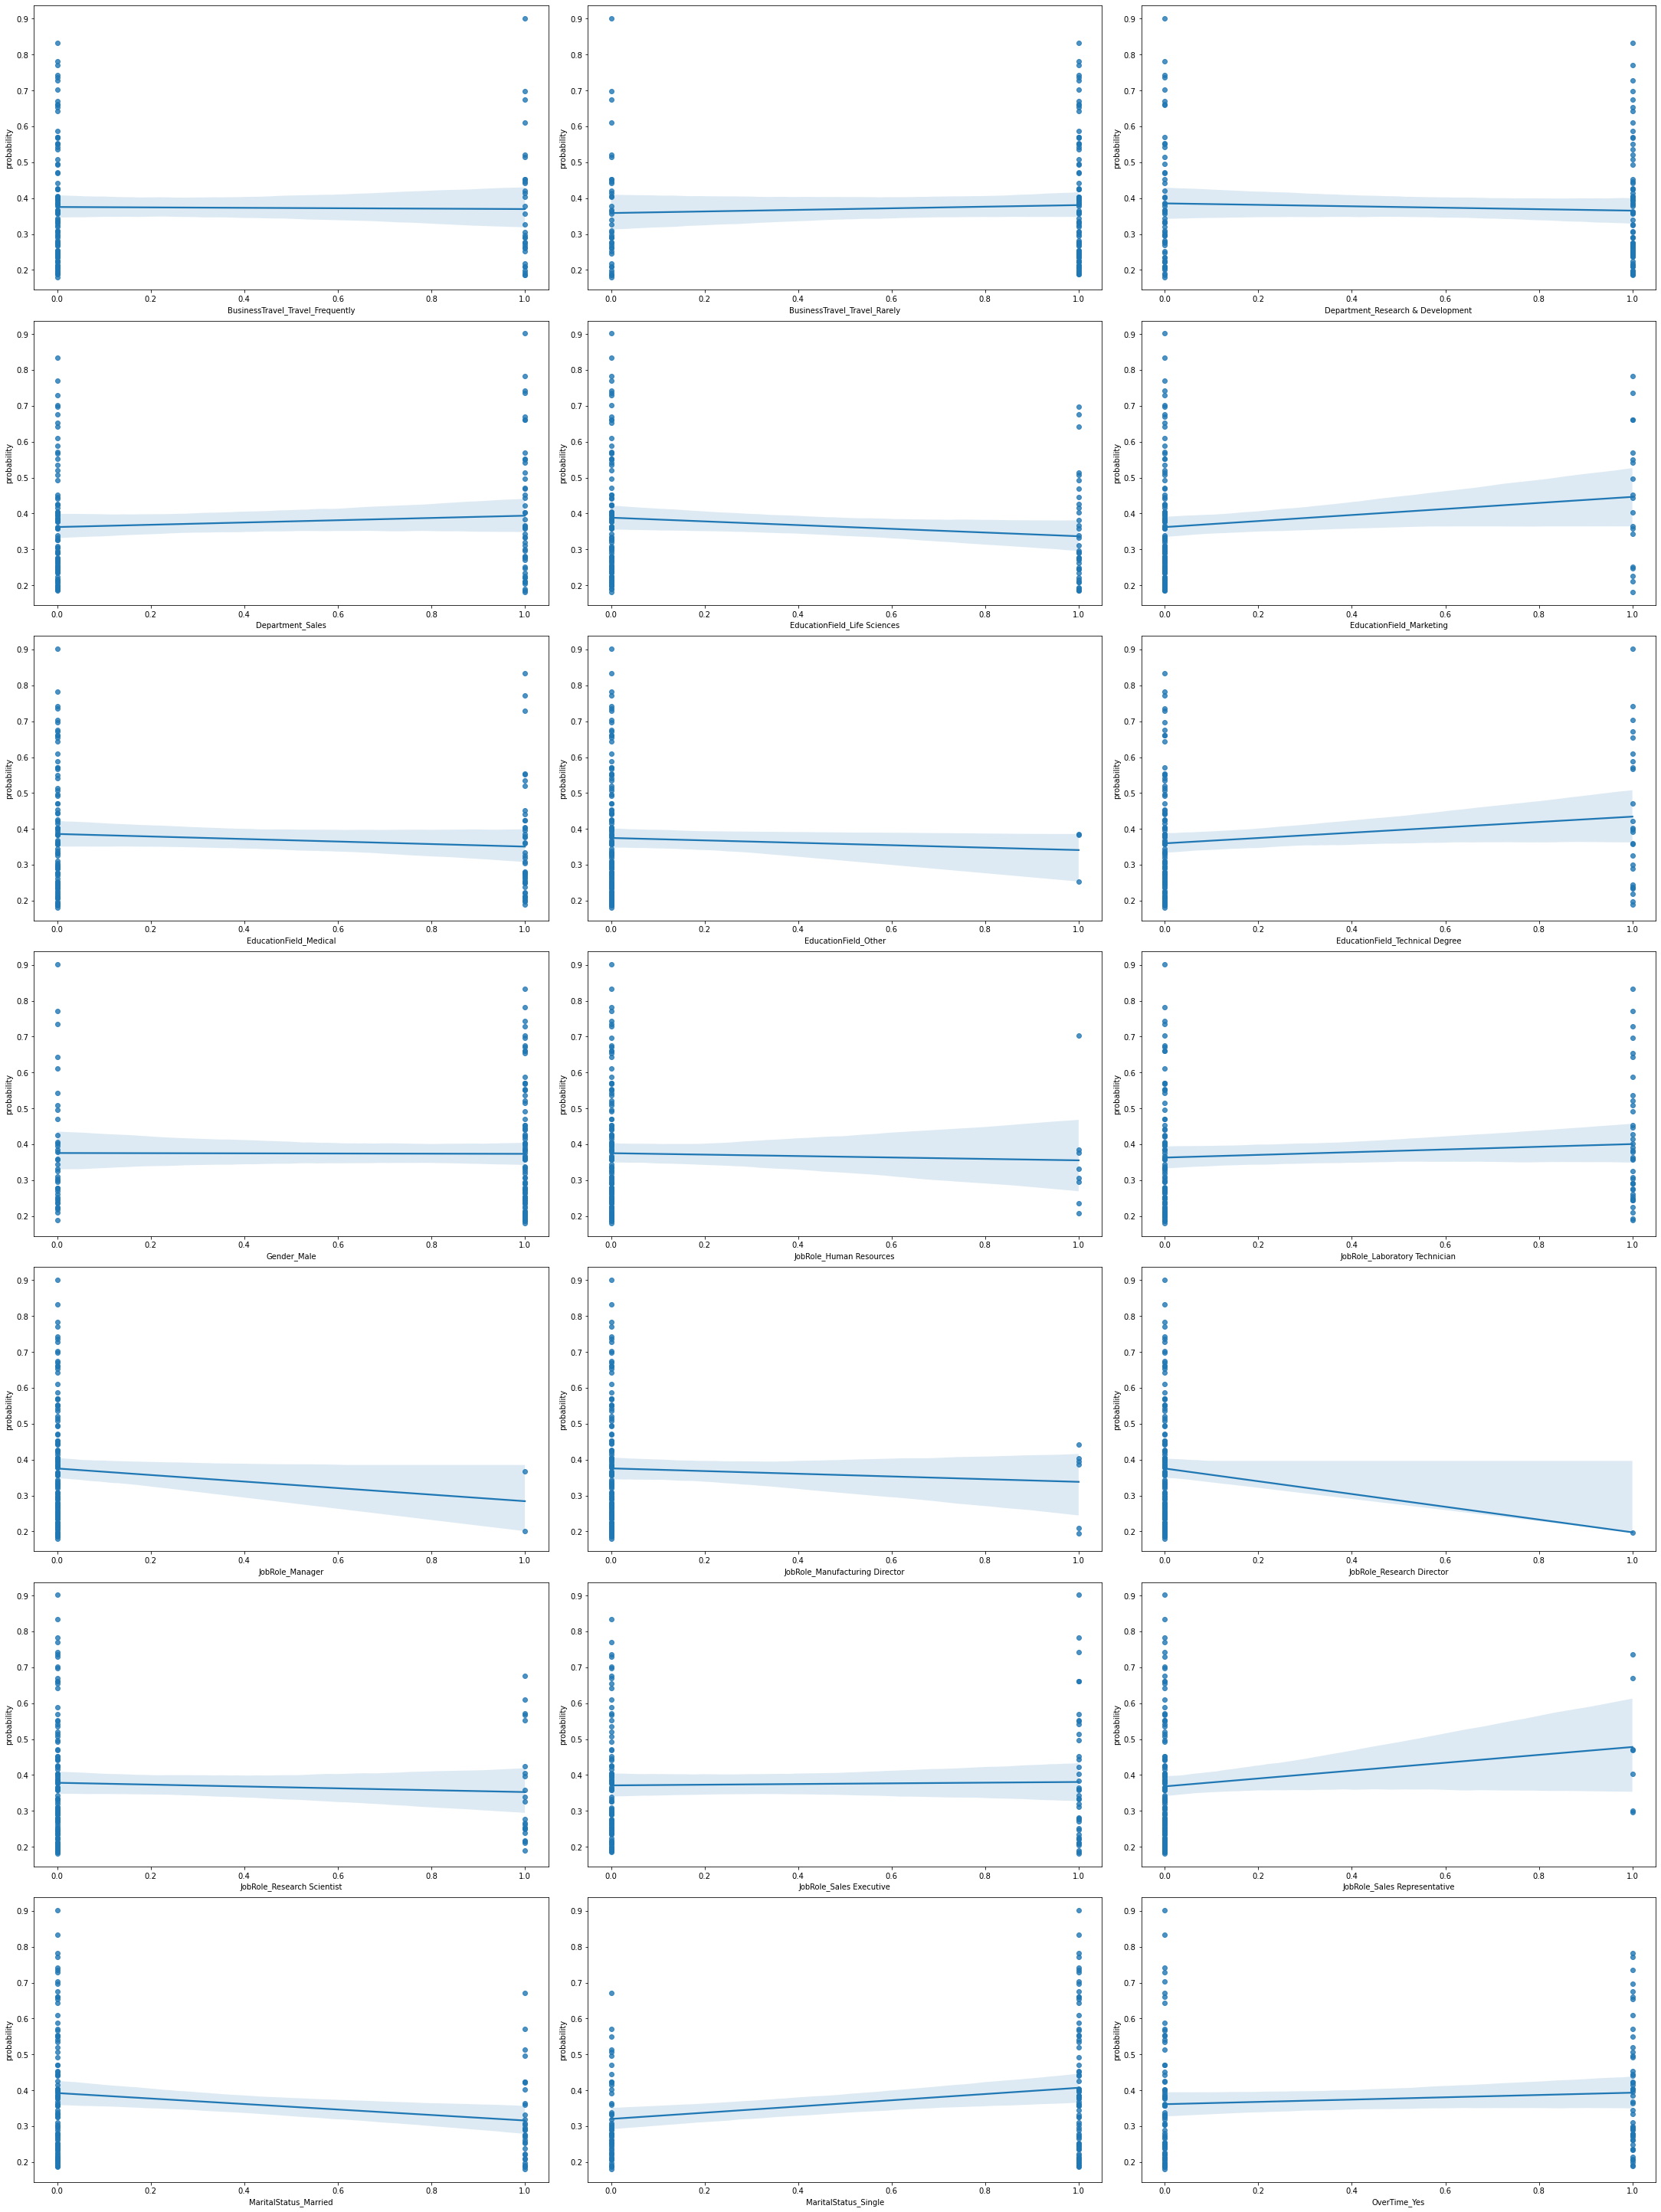

In [119]:
#Plotting the dummy variables against probability

fig,ax = plt.subplots(nrows = 7, ncols=3, figsize = (30, 40), layout = "constrained")
sns.regplot(x='BusinessTravel_Travel_Frequently', y='probability', data=merged_leave3, ax=ax[0,0])
sns.regplot(x='BusinessTravel_Travel_Rarely', y='probability', data=merged_leave3, ax=ax[0,1])
sns.regplot(x='Department_Research & Development', y='probability', data=merged_leave3, ax=ax[0,2])
sns.regplot(x='Department_Sales', y='probability', data=merged_leave3, ax=ax[1,0])
sns.regplot(x='EducationField_Life Sciences', y='probability', data=merged_leave3, ax=ax[1,1])
sns.regplot(x='EducationField_Marketing', y='probability', data=merged_leave3, ax=ax[1,2])
sns.regplot(x='EducationField_Medical', y='probability', data=merged_leave3, ax=ax[2,0])
sns.regplot(x='EducationField_Other', y='probability', data=merged_leave3, ax=ax[2,1])
sns.regplot(x='EducationField_Technical Degree', y='probability', data=merged_leave3, ax=ax[2,2])
sns.regplot(x='Gender_Male', y='probability', data=merged_leave3, ax=ax[3,0])
sns.regplot(x='JobRole_Human Resources', y='probability', data=merged_leave3, ax=ax[3,1])
sns.regplot(x='JobRole_Laboratory Technician', y='probability', data=merged_leave3, ax=ax[3,2])
sns.regplot(x='JobRole_Manager', y='probability', data=merged_leave3, ax=ax[4,0])
sns.regplot(x='JobRole_Manufacturing Director', y='probability', data=merged_leave3, ax=ax[4,1])
sns.regplot(x='JobRole_Research Director', y='probability', data=merged_leave3, ax=ax[4,2])
sns.regplot(x='JobRole_Research Scientist', y='probability', data=merged_leave3, ax=ax[5,0])
sns.regplot(x='JobRole_Sales Executive', y='probability', data=merged_leave3, ax=ax[5,1])
sns.regplot(x='JobRole_Sales Representative', y='probability', data=merged_leave3, ax=ax[5,2])
sns.regplot(x='MaritalStatus_Married', y='probability', data=merged_leave3, ax=ax[6,0])
sns.regplot(x='MaritalStatus_Single', y='probability', data=merged_leave3, ax=ax[6,1])
sns.regplot(x='OverTime_Yes', y='probability', data=merged_leave3, ax=ax[6,2])

In [123]:
#Refer to PDF Section A for reviewing the use of these averages

#Calculating the average of non-dummy variables responsible for a high probability of leaving i.e, higher the level
#of the dummy variable, higher the probability of leaving

leave_avg = ly_data5[["DistanceFromHome", "NumCompaniesWorked", "YearsSinceLastPromotion", "company_tenure_percentage"]].mean()
leave_avg

DistanceFromHome             9.459948
NumCompaniesWorked           2.786848
YearsSinceLastPromotion      2.346939
company_tenure_percentage    0.660483
dtype: float64

Next, we build out the employee categories for the purpose of optimising our decision variable i.e. which groups to be offered an RCC to.


#### Please refer to the optimization excel file and section B of the PDF for interpretation of the optimized model